# ODSB-15998: ITCT Analysis - All Clicks by IP

**Objective:** Analyze Impression-to-Click Time (ITCT) patterns for ALL clicks and identify if abnormal behaviors come from specific IPs.

**Advertiser:** `h4khOQuVmBR7OV2S`  
**Period:** 2026-01-01 to 2026-01-20

**Approach:** Analyze IP patterns at user level (not limited to 30+ click MTIDs)

---
### Colab: Authentication & Dependencies

In [130]:
# # Run this cell first in Google Colab
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated ✅')

In [1]:
# Setup
from google.cloud import bigquery
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

client = bigquery.Client(project='moloco-ods')

# Configuration
ADVERTISER_ID = 'h4khOQuVmBR7OV2S'
APP_BUNDLE = 'kr.co.station3.dabang'
START_DATE = '2026-01-01'
END_DATE = '2026-01-20'
MIN_CLICK_THRESHOLD = 30

print(f'Advertiser: {ADVERTISER_ID}')
print(f'Period: {START_DATE} to {END_DATE}')
print(f'Click Threshold: {MIN_CLICK_THRESHOLD}+ clicks per MTID')

Advertiser: h4khOQuVmBR7OV2S
Period: 2026-01-01 to 2026-01-20
Click Threshold: 30+ clicks per MTID


---
### Step 1: Compare click vs click_surplus tables (clicks per MTID)

In [132]:
# Q1: Does click table have only 1 click per MTID? vs click_surplus has multiple?
query_click_comparison = f"""
WITH click_table AS (
    SELECT
        bid.mtid,
        COUNT(*) AS click_count
    FROM `focal-elf-631.prod_stream_view.click`
    WHERE api.advertiser.id = '{ADVERTISER_ID}'
        AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
    GROUP BY bid.mtid
),
click_surplus_table AS (
    SELECT
        bid.mtid,
        COUNT(*) AS click_count
    FROM `focal-elf-631.prod_stream_view.click_surplus`
    WHERE api.advertiser.id = '{ADVERTISER_ID}'
        AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
    GROUP BY bid.mtid
)

SELECT
    'click' AS table_name,
    COUNT(*) AS total_mtids,
    SUM(click_count) AS total_clicks,
    AVG(click_count) AS avg_clicks_per_mtid,
    MAX(click_count) AS max_clicks_per_mtid,
    COUNTIF(click_count = 1) AS mtids_with_1_click,
    COUNTIF(click_count > 1) AS mtids_with_multiple_clicks
FROM click_table

UNION ALL

SELECT
    'click_surplus' AS table_name,
    COUNT(*) AS total_mtids,
    SUM(click_count) AS total_clicks,
    AVG(click_count) AS avg_clicks_per_mtid,
    MAX(click_count) AS max_clicks_per_mtid,
    COUNTIF(click_count = 1) AS mtids_with_1_click,
    COUNTIF(click_count > 1) AS mtids_with_multiple_clicks
FROM click_surplus_table
"""

df_click_comparison = client.query(query_click_comparison).to_dataframe()
print("=" * 70)
print("Q1: Click vs Click_Surplus Table Comparison")
print("=" * 70)
print(df_click_comparison.to_string(index=False))
print("\n→ If click table has mostly 1 click per MTID, it logs only the FIRST valid click.")

query_suspicious_mtid = f"""
WITH event AS (
    SELECT
        req.device.ifa,
        req.exchange,
        req.app.bundle,
        req.app.publisher.id AS publisher_id,
        req.app.publisher.name AS publisher_name,
        req.imp.tagid,
        cv.pb.event.name as event_name,
        cv.received_at as event_timestamp,
        bid.timestamp as bid_timestamp,
        imp.received_at as imp_timestamp,
        click.received_at as click_timestamp,
        REGEXP_EXTRACT(cv.pb.payload.raw, r'&moloco_mtid=([^&]*)') AS mtid_value,
    FROM `focal-elf-631.prod_stream_view.cv`
    WHERE api.advertiser.id = '{ADVERTISER_ID}'
        AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
)

SELECT
    ifa,
    exchange,
    bundle,
    tagid,
    mtid_value,
    event_name,
    COUNT(DISTINCT click_timestamp) AS click_cnt,
    COUNT(DISTINCT event_timestamp) AS event_cnt
FROM event
WHERE event_name = 'deeplink'
GROUP BY ALL
HAVING event_cnt > {MIN_CLICK_THRESHOLD}
ORDER BY event_cnt DESC
"""

df_suspicious_mtid = client.query(query_suspicious_mtid).to_dataframe()
print(f"Suspicious MTIDs with {MIN_CLICK_THRESHOLD}+ clicks: {len(df_suspicious_mtid)}")
print(f"Unique IFAs: {df_suspicious_mtid['ifa'].nunique()}")
print(f"Unique Publishers: {df_suspicious_mtid['bundle'].nunique()}")
df_suspicious_mtid.head(20)

Q1: Click vs Click_Surplus Table Comparison
   table_name  total_mtids  total_clicks  avg_clicks_per_mtid  max_clicks_per_mtid  mtids_with_1_click  mtids_with_multiple_clicks
        click       757177        757179             1.000003                    2              757175                           2
click_surplus       183465        387988             2.114779                  903              115022                       68443

→ If click table has mostly 1 click per MTID, it logs only the FIRST valid click.
Suspicious MTIDs with 30+ clicks: 22
Unique IFAs: 5
Unique Publishers: 3


,ifa,exchange,bundle,tagid,mtid_value,event_name,click_cnt,event_cnt
0,739e2e23-4d76-44b9-9067-3a8676c6e2ae,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6628a58e8c8d1d780dbb6ffb,ChD8thKOosFLo4Prqygk1MwwEJ-t-coGGhQIARoQc54uI0...,deeplink,1,96
1,739e2e23-4d76-44b9-9067-3a8676c6e2ae,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6628a58e8c8d1d780dbb6ffb,ChD4ENFwgKJL0Z10t6KEz-HFEPH1qMsGGhQIARoQc54uI0...,deeplink,1,79
2,cb16bfcd-608f-42a6-abe4-738ba75bdb1e,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6628a58e8c8d1d780dbb6ffb,ChBXmcUT7AdKkp55mndOhCCjELnnh8sGGhQIARoQyxa_zW...,deeplink,1,74
3,cb16bfcd-608f-42a6-abe4-738ba75bdb1e,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6618f23e8c8d1d6afd52744e,ChAYOrqG-9hDt6j_RSmX9j54EIai3soGGhQIARoQyxa_zW...,deeplink,1,70
4,5b260e61-b287-4fa6-b85d-7206dc51192c,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6618f23e8c8d1d6afd52744e,ChDfwQk0xkVMibkE9AzZxlaCEIjS_MoGGhQIARoQWyYOYb...,deeplink,1,62
5,cb16bfcd-608f-42a6-abe4-738ba75bdb1e,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6618f2638c8d1d6a54cdc3ae,ChA3B5QBdQNC8ZY8RAjU_oxfEN3u_coGGhQIARoQyxa_zW...,deeplink,1,61
6,cb16bfcd-608f-42a6-abe4-738ba75bdb1e,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6618f23e8c8d1d6afd52744e,ChAkgf4DrjpC6pCJqxj1KK6VENXph8sGGhQIARoQyxa_zW...,deeplink,1,60
7,cb16bfcd-608f-42a6-abe4-738ba75bdb1e,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6628a58e8c8d1d780dbb6ffb,ChC60Xox4LVH2YqjgVKIE23jEP2h3soGGhQIARoQyxa_zW...,deeplink,1,59
8,739e2e23-4d76-44b9-9067-3a8676c6e2ae,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6618f23e8c8d1d6afd52744e,ChCnX1CR6xdG4oI93PF0t_QlEKet-coGGhQIARoQc54uI0...,deeplink,1,54
9,739e2e23-4d76-44b9-9067-3a8676c6e2ae,ADPIE,com.ltlk,56b4002f7174ea39c74df8aa:6628a58e8c8d1d780dbb6ffb,ChBSpImwJ_xOvoNACMPrcbySEI-45MoGGhQIARoQc54uI0...,deeplink,1,47


---
### Step 2: Deeplink Event Time vs Click Time Comparison

In [133]:
query_deeplink_vs_click = f"""
WITH deeplink_events AS (
    SELECT
        REGEXP_EXTRACT(cv.pb.payload.raw, r'&moloco_mtid=([^&]*)') AS mtid_value,
        cv.received_at AS deeplink_timestamp,
        req.device.ifa
    FROM `focal-elf-631.prod_stream_view.cv`
    WHERE api.advertiser.id = '{ADVERTISER_ID}'
        AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
        AND cv.pb.event.name = 'deeplink'
),
click_surplus_events AS (
    SELECT
        bid.mtid,
        click.happened_at AS click_timestamp,
        req.device.ifa
    FROM `focal-elf-631.prod_stream_view.click_surplus`
    WHERE api.advertiser.id = '{ADVERTISER_ID}'
        AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
)

SELECT
    d.mtid_value,
    d.ifa,
    d.deeplink_timestamp,
    c.click_timestamp,
    TIMESTAMP_DIFF(d.deeplink_timestamp, c.click_timestamp, SECOND) AS deeplink_minus_click_sec
FROM deeplink_events d
JOIN click_surplus_events c
    ON d.mtid_value = c.mtid AND d.ifa = c.ifa
WHERE d.mtid_value IS NOT NULL
ORDER BY ABS(TIMESTAMP_DIFF(d.deeplink_timestamp, c.click_timestamp, SECOND)) DESC
LIMIT 1000
"""

df_deeplink_vs_click = client.query(query_deeplink_vs_click).to_dataframe()

print("=" * 70)
print("Q1-1: Deeplink Event Time vs Click Time (click_surplus)")
print("=" * 70)
print(f"\nSample size: {len(df_deeplink_vs_click)}")
print(f"\nTime Difference (deeplink - click) in seconds:")
print(df_deeplink_vs_click['deeplink_minus_click_sec'].describe())

print(f"\nDistribution of time difference:")
bins = [-float('inf'), -60, -10, -1, 0, 1, 10, 60, float('inf')]
labels = ['<-60s', '-60 to -10s', '-10 to -1s', '-1 to 0s', '0 to 1s', '1 to 10s', '10 to 60s', '>60s']
df_deeplink_vs_click['diff_bucket'] = pd.cut(df_deeplink_vs_click['deeplink_minus_click_sec'], bins=bins, labels=labels)
print(df_deeplink_vs_click['diff_bucket'].value_counts().sort_index())


query_itct = f"""
SELECT
    req.device.ifa,
    req.device.ip,
    bid.mtid,
    req.exchange,
    req.app.bundle,
    req.app.publisher.id AS publisher_id,
    req.app.publisher.name AS publisher_name,
    req.imp.tagid,
    imp.happened_at AS imp_timestamp,
    click.happened_at AS click_timestamp,
    TIMESTAMP_DIFF(click.happened_at, imp.happened_at, MILLISECOND) AS itct_ms,
    TIMESTAMP_DIFF(click.happened_at, imp.happened_at, SECOND) AS itct_sec,
    click_surplus.reason AS click_surplus_reason
FROM `focal-elf-631.prod_stream_view.click_surplus`
WHERE api.advertiser.id = '{ADVERTISER_ID}'
    AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
ORDER BY req.device.ifa, imp.happened_at, click.happened_at
"""

df_itct = client.query(query_itct).to_dataframe()
print(f"Total click records: {len(df_itct):,}")
print(f"Unique IFAs: {df_itct['ifa'].nunique():,}")
print(f"Unique IPs: {df_itct['ip'].nunique():,}")
print(f"Unique MTIDs: {df_itct['mtid'].nunique():,}")
df_itct.head(20)

Q1-1: Deeplink Event Time vs Click Time (click_surplus)

Sample size: 1000

Time Difference (deeplink - click) in seconds:
count         1000.0
mean       66539.397
std      14871.32364
min        -225656.0
25%          57656.0
50%          65367.5
75%         75966.25
max         111364.0
Name: deeplink_minus_click_sec, dtype: Float64

Distribution of time difference:
diff_bucket
<-60s            2
-60 to -10s      0
-10 to -1s       0
-1 to 0s         0
0 to 1s          0
1 to 10s         0
10 to 60s        0
>60s           998
Name: count, dtype: int64
Total click records: 387,988
Unique IFAs: 77,177
Unique IPs: 80,106
Unique MTIDs: 183,465


,ifa,ip,mtid,exchange,bundle,publisher_id,publisher_name,tagid,imp_timestamp,click_timestamp,itct_ms,itct_sec,click_surplus_reason
0,,118.235.74,ChCwstJd-aFA3a7QnHjpL3lYEJHT2coGGhQIBRoQs33h20...,KAKAO,com.kakao.talk,0,Daum Kakao Corp.,DAN-9PaWqQNQpqtf5FFM,NaT,2026-01-01 12:33:27.815026+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
1,,211.235.90,ChBmnX1rCXdI6pu2fxuMk2AKELSl7coGGhQIBRoQtb8txE...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-fu8OO1UnClBkAZJI,NaT,2026-01-05 05:57:09.314092+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
2,,106.101.196,ChCYGPN4kHlLQYgx3Yg9oNRYENDu7coGGhQIBRoQOflZ0D...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-fXGthnQXmT8bskWu,NaT,2026-01-05 08:33:21.933582+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
3,,211.235.80,ChCmIAhi7tVEXqpYouE2FiNsEILRicsGGhQIBRoQW3-a4v...,KAKAO,com.kakao.talk,0,Daum Kakao Corp.,DAN-eIoAe5gVGnPuUvys,NaT,2026-01-10 14:56:03.319808+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
4,,118.235.92,ChAawPwaLtxMW7oyCNtWzdyjEK312MoGGhQIBRoQq43vKB...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-1ib3qn9ggkhtc,2026-01-01 09:13:17.514568+00:00,2026-01-01 09:13:28.069705+00:00,10555,10,"IGNORE_REPORT_TO_MMP,REDUNDANT"
5,,182.231.26,ChAhFGMTzRlNJLsujzL3GFNQEJac2coGGhQIBRoQgJE3iZ...,KAKAO,com.jobkorea.app,vOc,GENERAL,DAN-BjCQma5Oay7mt7HU,2026-01-01 10:36:08.365337+00:00,2026-01-01 10:36:37.841352+00:00,29476,29,"IGNORE_REPORT_TO_MMP,REDUNDANT"
6,,106.101.80,ChC2xoYX5u1E15ImgrnZh9NuEJPa2soGGhQIBRoQouqYpb...,KAKAO,com.kakao.talk,0,Daum Kakao Corp.,DAN-kUTB5NrFaPR9bAKq,2026-01-01 17:21:24.625163+00:00,2026-01-01 17:21:25.822350+00:00,1197,1,"IGNORE_REPORT_TO_MMP,REDUNDANT"
7,,223.39.80,ChAaee1rrnJOHJ40NO0yqwv2EIan3MoGGhQIBRoQaqvwaz...,KAKAO,com.skt.prod.dialer,leN,GENERAL,DAN-D765XmBR7qyQcGdU,2026-01-02 00:38:32.572828+00:00,2026-01-02 00:38:40.328680+00:00,7755,7,"IGNORE_REPORT_TO_MMP,REDUNDANT"
8,,106.101.69,ChDAJwzuh7VCrJw7w6jNmKU4EO2i3soGGhQIBRoQYmVQ0l...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-fXGthnQXmT8bskWu,2026-01-02 09:35:42.012723+00:00,2026-01-02 09:35:43.421316+00:00,1408,1,"IGNORE_REPORT_TO_MMP,REDUNDANT"
9,,211.235.88,ChAVJ43pDaZHgK8GPgDvHHeIEJjR4coGGhQIBRoQIzbIzb...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-1iykzv03dd4rq,2026-01-03 00:53:45.344225+00:00,2026-01-03 00:53:51.888636+00:00,6544,6,"IGNORE_REPORT_TO_MMP,REDUNDANT"


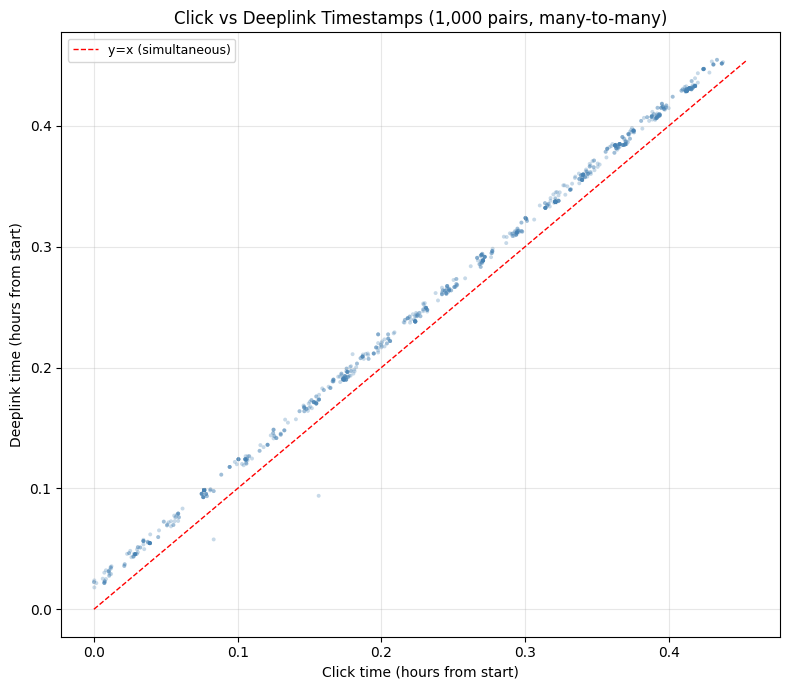


Points off the diagonal = large time gap between click and deeplink.
Pairs per MTID — median: 1, p95: 6, max: 30


In [134]:
import matplotlib.pyplot as plt
import numpy as np

if not df_deeplink_vs_click.empty:
    df_plot = df_deeplink_vs_click.copy()
    df_plot['click_ts_num'] = pd.to_numeric(df_plot['click_timestamp'].astype(np.int64) // 10**9)
    df_plot['deeplink_ts_num'] = pd.to_numeric(df_plot['deeplink_timestamp'].astype(np.int64) // 10**9)
    t_min = min(df_plot['click_ts_num'].min(), df_plot['deeplink_ts_num'].min())
    df_plot['click_offset_hr'] = (df_plot['click_ts_num'] - t_min) / 3600
    df_plot['deeplink_offset_hr'] = (df_plot['deeplink_ts_num'] - t_min) / 3600

    fig, ax = plt.subplots(figsize=(8, 7))
    ax.scatter(df_plot['click_offset_hr'], df_plot['deeplink_offset_hr'],
               alpha=0.3, s=8, c='steelblue', edgecolors='none')
    lims = [0, max(df_plot['click_offset_hr'].max(), df_plot['deeplink_offset_hr'].max())]
    ax.plot(lims, lims, 'r--', linewidth=1, label='y=x (simultaneous)')
    ax.set_xlabel('Click time (hours from start)')
    ax.set_ylabel('Deeplink time (hours from start)')
    ax.set_title(f'Click vs Deeplink Timestamps ({len(df_plot):,} pairs, many-to-many)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nPoints off the diagonal = large time gap between click and deeplink.")
    pairs_per_mtid = df_deeplink_vs_click.groupby('mtid_value').size()
    print(f"Pairs per MTID — median: {pairs_per_mtid.median():.0f}, p95: {pairs_per_mtid.quantile(0.95):.0f}, max: {pairs_per_mtid.max()}")
else:
    print("No deeplink vs click data to visualize.")

---
### Step 3: Get ITCT (Impression to Click Time) with IP for ALL Clicks

In [135]:
query_itct = f"""
SELECT
    req.device.ifa,
    req.device.ip,
    bid.mtid,
    req.exchange,
    req.app.bundle,
    req.app.publisher.id AS publisher_id,
    req.app.publisher.name AS publisher_name,
    req.imp.tagid,
    imp.happened_at AS imp_timestamp,
    click.happened_at AS click_timestamp,
    TIMESTAMP_DIFF(click.happened_at, imp.happened_at, MILLISECOND) AS itct_ms,
    TIMESTAMP_DIFF(click.happened_at, imp.happened_at, SECOND) AS itct_sec,
    click_surplus.reason AS click_surplus_reason
FROM `focal-elf-631.prod_stream_view.click_surplus`
WHERE api.advertiser.id = '{ADVERTISER_ID}'
    AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
ORDER BY req.device.ifa, imp.happened_at, click.happened_at
"""

df_itct = client.query(query_itct).to_dataframe()
print(f"Total click records: {len(df_itct):,}")
print(f"Unique IFAs: {df_itct['ifa'].nunique():,}")
print(f"Unique IPs: {df_itct['ip'].nunique():,}")
print(f"Unique MTIDs: {df_itct['mtid'].nunique():,}")
df_itct.head(20)

Total click records: 387,988
Unique IFAs: 77,177
Unique IPs: 80,106
Unique MTIDs: 183,465


,ifa,ip,mtid,exchange,bundle,publisher_id,publisher_name,tagid,imp_timestamp,click_timestamp,itct_ms,itct_sec,click_surplus_reason
0,,118.235.74,ChCwstJd-aFA3a7QnHjpL3lYEJHT2coGGhQIBRoQs33h20...,KAKAO,com.kakao.talk,0,Daum Kakao Corp.,DAN-9PaWqQNQpqtf5FFM,NaT,2026-01-01 12:33:27.815026+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
1,,211.235.90,ChBmnX1rCXdI6pu2fxuMk2AKELSl7coGGhQIBRoQtb8txE...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-fu8OO1UnClBkAZJI,NaT,2026-01-05 05:57:09.314092+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
2,,106.101.196,ChCYGPN4kHlLQYgx3Yg9oNRYENDu7coGGhQIBRoQOflZ0D...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-fXGthnQXmT8bskWu,NaT,2026-01-05 08:33:21.933582+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
3,,211.235.80,ChCmIAhi7tVEXqpYouE2FiNsEILRicsGGhQIBRoQW3-a4v...,KAKAO,com.kakao.talk,0,Daum Kakao Corp.,DAN-eIoAe5gVGnPuUvys,NaT,2026-01-10 14:56:03.319808+00:00,<NA>,<NA>,IGNORE_REPORT_TO_MMP
4,,118.235.92,ChAawPwaLtxMW7oyCNtWzdyjEK312MoGGhQIBRoQq43vKB...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-1ib3qn9ggkhtc,2026-01-01 09:13:17.514568+00:00,2026-01-01 09:13:28.069705+00:00,10555,10,"IGNORE_REPORT_TO_MMP,REDUNDANT"
5,,182.231.26,ChAhFGMTzRlNJLsujzL3GFNQEJac2coGGhQIBRoQgJE3iZ...,KAKAO,com.jobkorea.app,vOc,GENERAL,DAN-BjCQma5Oay7mt7HU,2026-01-01 10:36:08.365337+00:00,2026-01-01 10:36:37.841352+00:00,29476,29,"IGNORE_REPORT_TO_MMP,REDUNDANT"
6,,106.101.80,ChC2xoYX5u1E15ImgrnZh9NuEJPa2soGGhQIBRoQouqYpb...,KAKAO,com.kakao.talk,0,Daum Kakao Corp.,DAN-kUTB5NrFaPR9bAKq,2026-01-01 17:21:24.625163+00:00,2026-01-01 17:21:25.822350+00:00,1197,1,"IGNORE_REPORT_TO_MMP,REDUNDANT"
7,,223.39.80,ChAaee1rrnJOHJ40NO0yqwv2EIan3MoGGhQIBRoQaqvwaz...,KAKAO,com.skt.prod.dialer,leN,GENERAL,DAN-D765XmBR7qyQcGdU,2026-01-02 00:38:32.572828+00:00,2026-01-02 00:38:40.328680+00:00,7755,7,"IGNORE_REPORT_TO_MMP,REDUNDANT"
8,,106.101.69,ChDAJwzuh7VCrJw7w6jNmKU4EO2i3soGGhQIBRoQYmVQ0l...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-fXGthnQXmT8bskWu,2026-01-02 09:35:42.012723+00:00,2026-01-02 09:35:43.421316+00:00,1408,1,"IGNORE_REPORT_TO_MMP,REDUNDANT"
9,,211.235.88,ChAVJ43pDaZHgK8GPgDvHHeIEJjR4coGGhQIBRoQIzbIzb...,KAKAO,net.daum.android.daum,0,Daum Kakao Corp.,DAN-1iykzv03dd4rq,2026-01-03 00:53:45.344225+00:00,2026-01-03 00:53:51.888636+00:00,6544,6,"IGNORE_REPORT_TO_MMP,REDUNDANT"


---
### Step 4: Clicks per MTID Distribution — Define Threshold

Clicks per MTID Distribution

Total unique MTIDs: 183,465

Distribution:
  p 50.0:      1 clicks  (183,465 MTIDs at or above)
  p 75.0:      2 clicks  (68,443 MTIDs at or above)
  p 90.0:      5 clicks  (18,777 MTIDs at or above)
  p 95.0:      5 clicks  (18,777 MTIDs at or above)
  p 99.0:     10 clicks  (1,938 MTIDs at or above)
  p 99.5:     13 clicks  (948 MTIDs at or above)
  p 99.9:     55 clicks  (184 MTIDs at or above)
  max:      903 clicks

MTIDs with 1 click:   115,022 (62.7%)
MTIDs with 2-9:       66,505
MTIDs with 10-29:     1,630
MTIDs with 30-49:     115
MTIDs with 50+:       193


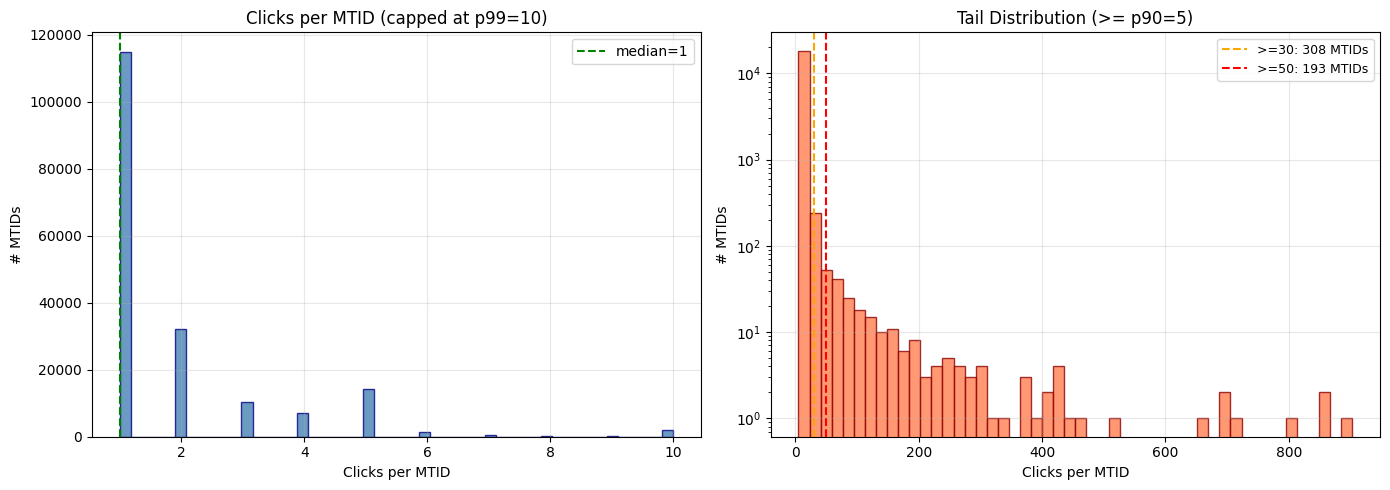


→ MTID_CLICK_THRESHOLD set to 30
  MTIDs above threshold: 308 (0.17%)


In [136]:
import matplotlib.pyplot as plt

print("=" * 60)
print("Clicks per MTID Distribution")
print("=" * 60)

clicks_per_mtid = df_itct.groupby('mtid').size().rename('clicks')

print(f"\nTotal unique MTIDs: {len(clicks_per_mtid):,}")
print(f"\nDistribution:")
for p in [50, 75, 90, 95, 99, 99.5, 99.9]:
    val = clicks_per_mtid.quantile(p / 100)
    n_above = (clicks_per_mtid >= val).sum()
    print(f"  p{p:5.1f}: {val:>6.0f} clicks  ({n_above:,} MTIDs at or above)")

print(f"  max:   {clicks_per_mtid.max():>6} clicks")
print(f"\nMTIDs with 1 click:   {(clicks_per_mtid == 1).sum():,} ({100*(clicks_per_mtid == 1).mean():.1f}%)")
print(f"MTIDs with 2-9:       {((clicks_per_mtid >= 2) & (clicks_per_mtid <= 9)).sum():,}")
print(f"MTIDs with 10-29:     {((clicks_per_mtid >= 10) & (clicks_per_mtid <= 29)).sum():,}")
print(f"MTIDs with 30-49:     {((clicks_per_mtid >= 30) & (clicks_per_mtid <= 49)).sum():,}")
print(f"MTIDs with 50+:       {(clicks_per_mtid >= 50).sum():,}")

# Histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: full distribution (capped at p99)
cap = int(clicks_per_mtid.quantile(0.99))
ax1.hist(clicks_per_mtid.clip(upper=cap), bins=50, color='steelblue', edgecolor='navy', alpha=0.8)
ax1.set_xlabel('Clicks per MTID')
ax1.set_ylabel('# MTIDs')
ax1.set_title(f'Clicks per MTID (capped at p99={cap})')
ax1.axvline(x=clicks_per_mtid.median(), color='green', linestyle='--', label=f'median={clicks_per_mtid.median():.0f}')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: tail (>= p90) with log scale
p90 = int(clicks_per_mtid.quantile(0.90))
tail = clicks_per_mtid[clicks_per_mtid >= p90]
ax2.hist(tail, bins=50, color='coral', edgecolor='darkred', alpha=0.8)
ax2.set_xlabel('Clicks per MTID')
ax2.set_ylabel('# MTIDs')
ax2.set_title(f'Tail Distribution (>= p90={p90})')
ax2.set_yscale('log')
for thresh in [30, 50]:
    n = (clicks_per_mtid >= thresh).sum()
    ax2.axvline(x=thresh, color='red' if thresh == 50 else 'orange', linestyle='--',
                label=f'>={thresh}: {n:,} MTIDs')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()

# Set threshold based on distribution
MTID_CLICK_THRESHOLD = 30  #@param {type:"integer"}
print(f"\n→ MTID_CLICK_THRESHOLD set to {MTID_CLICK_THRESHOLD}")
print(f"  MTIDs above threshold: {(clicks_per_mtid >= MTID_CLICK_THRESHOLD).sum():,} "
      f"({100*(clicks_per_mtid >= MTID_CLICK_THRESHOLD).mean():.2f}%)")

---
### Step 5: ITCT Comparison — 30+ Click MTIDs vs Normal Users (<5 clicks)

In [137]:
print("=" * 70)
print(f"Q2: Do users with suspicious MTIDs ({MTID_CLICK_THRESHOLD}+ clicks) show delayed clicks?")
print("=" * 70)

# Calculate clicks per MTID
df_mtid_stats = df_itct.groupby(['mtid', 'ifa']).agg({
    'click_timestamp': 'count',
    'itct_sec': 'mean'
}).reset_index()
df_mtid_stats.columns = ['mtid', 'ifa', 'clicks_per_mtid', 'avg_itct_sec']

# Categorize MTIDs
df_mtid_stats['mtid_category'] = pd.cut(
    df_mtid_stats['clicks_per_mtid'],
    bins=[0, 1, 5, MTID_CLICK_THRESHOLD, float('inf')],
    labels=['1 click', '2-5 clicks', f'6-{MTID_CLICK_THRESHOLD} clicks', f'{MTID_CLICK_THRESHOLD}+ clicks']
)

# Get unique IFAs per category
suspicious_ifas = set(df_mtid_stats[df_mtid_stats['clicks_per_mtid'] >= MTID_CLICK_THRESHOLD]['ifa'].unique())
normal_ifas = set(df_mtid_stats[df_mtid_stats['clicks_per_mtid'] < 5]['ifa'].unique())

# IFAs that are ONLY suspicious (never have normal MTIDs)
suspicious_only_ifas = suspicious_ifas - normal_ifas
normal_only_ifas = normal_ifas - suspicious_ifas

print(f"\nUser (IFA) Categories:")
print(f"  Users with {MTID_CLICK_THRESHOLD}+ click MTIDs: {len(suspicious_ifas):,}")
print(f"  Users with <5 click MTIDs: {len(normal_ifas):,}")
print(f"  Users with ONLY {MTID_CLICK_THRESHOLD}+ click MTIDs: {len(suspicious_only_ifas):,}")
print(f"  Users with ONLY <5 click MTIDs: {len(normal_only_ifas):,}")

# Compare ITCT by user category
df_itct['user_category'] = df_itct['ifa'].apply(
    lambda x: 'Suspicious Only' if x in suspicious_only_ifas 
    else ('Normal Only' if x in normal_only_ifas else 'Mixed')
)

print(f"\nITCT by User Category:")
itct_by_user = df_itct.groupby('user_category')['itct_sec'].agg(['count', 'mean', 'median', 'std']).round(2)
print(itct_by_user)

# ITCT distribution comparison
print(f"\nITCT Percentiles by User Category:")
for cat in ['Suspicious Only', 'Normal Only', 'Mixed']:
    subset = df_itct[df_itct['user_category'] == cat]['itct_sec']
    if len(subset) > 0:
        print(f"\n  {cat}:")
        for p in [0.25, 0.5, 0.75, 0.9, 0.95]:
            print(f"    P{int(p*100)}: {subset.quantile(p):.2f} sec")

Q2: Do users with suspicious MTIDs (30+ clicks) show delayed clicks?

User (IFA) Categories:
  Users with 30+ click MTIDs: 110
  Users with <5 click MTIDs: 64,989
  Users with ONLY 30+ click MTIDs: 63
  Users with ONLY <5 click MTIDs: 64,942

ITCT by User Category:
                  count       mean  median        std
user_category                                        
Mixed            112755   30298.13   202.0  180862.68
Normal Only      231039    2974.36    21.0   97068.17
Suspicious Only    4908  175852.14  4502.5  743159.73

ITCT Percentiles by User Category:

  Suspicious Only:
    P25: 219.00 sec
    P50: 4502.50 sec
    P75: 29638.00 sec
    P90: 194325.30 sec
    P95: 876620.45 sec

  Normal Only:
    P25: 6.00 sec
    P50: 21.00 sec
    P75: 48.00 sec
    P90: 162.00 sec
    P95: 636.00 sec

  Mixed:
    P25: 68.00 sec
    P50: 202.00 sec
    P75: 12473.50 sec
    P90: 38003.60 sec
    P95: 129196.90 sec


---
### Step 6: Patterns in Highly Delayed Clicks (ITCT > X seconds)

In [138]:
# Counting DISTINCT MTIDs (not clicks) - one MTID can have both delayed and normal clicks

print("=" * 70)
print("Q3: Patterns in Highly Delayed Clicks (by distinct MTID)")
print("=" * 70)

# Define delay thresholds
DELAY_THRESHOLD_SEC = 150  # Consider clicks >150 seconds as "highly delayed"

df_itct['is_delayed'] = df_itct['itct_sec'] > DELAY_THRESHOLD_SEC

# Get MTIDs with delayed/normal clicks
delayed_mtids = set(df_itct[df_itct['is_delayed']]['mtid'].unique())
normal_mtids = set(df_itct[~df_itct['is_delayed']]['mtid'].unique())
all_mtids = set(df_itct['mtid'].unique())

print(f"\nDelay Threshold: {DELAY_THRESHOLD_SEC} seconds")
print(f"Total unique MTIDs: {len(all_mtids):,}")
print(f"MTIDs with delayed clicks (>{DELAY_THRESHOLD_SEC}s): {len(delayed_mtids):,} ({len(delayed_mtids)/len(all_mtids)*100:.1f}%)")
print(f"MTIDs with normal clicks: {len(normal_mtids):,}")
print(f"MTIDs with BOTH delayed & normal: {len(delayed_mtids & normal_mtids):,}")

# Helper function to count distinct MTIDs by dimension
def count_mtids_by_dimension(df, dimension_cols):
    """Count distinct MTIDs with delayed/normal clicks per dimension"""
    if isinstance(dimension_cols, str):
        dimension_cols = [dimension_cols]
    
    # Get unique MTIDs per dimension for delayed and normal
    delayed_df = df[df['is_delayed']].groupby(dimension_cols)['mtid'].nunique().reset_index()
    delayed_df.columns = dimension_cols + ['delayed_mtids']
    
    normal_df = df[~df['is_delayed']].groupby(dimension_cols)['mtid'].nunique().reset_index()
    normal_df.columns = dimension_cols + ['normal_mtids']
    
    total_df = df.groupby(dimension_cols)['mtid'].nunique().reset_index()
    total_df.columns = dimension_cols + ['total_mtids']
    
    # Merge all
    result = total_df.merge(delayed_df, on=dimension_cols, how='left').merge(normal_df, on=dimension_cols, how='left')
    result = result.fillna(0)
    result['delayed_mtids'] = result['delayed_mtids'].astype(int)
    result['normal_mtids'] = result['normal_mtids'].astype(int)
    result['delayed_pct'] = (result['delayed_mtids'] / result['total_mtids'] * 100).round(1)
    
    return result

# By Exchange (top 30 by delayed_mtids, sorted by delayed_pct)
print(f"\n--- By Exchange (Top 30 by delayed_mtids, sorted by delayed_pct DESC) ---")
exchange_comparison = count_mtids_by_dimension(df_itct, 'exchange')
exchange_top30 = exchange_comparison.nlargest(30, 'delayed_mtids').sort_values('delayed_pct', ascending=False)
print(exchange_top30.to_string(index=False))

# By Publisher (top 30 by delayed_mtids, sorted by delayed_pct)
print(f"\n--- By Publisher (Top 30 by delayed_mtids, sorted by delayed_pct DESC) ---")
pub_comparison = count_mtids_by_dimension(df_itct, ['bundle', 'publisher_name'])
pub_top30 = pub_comparison.nlargest(30, 'delayed_mtids').sort_values('delayed_pct', ascending=False)
print(pub_top30.to_string(index=False))

# By IP (top 30 by delayed_mtids, sorted by delayed_pct)
print(f"\n--- By IP (Top 30 by delayed_mtids, sorted by delayed_pct DESC) ---")
ip_comparison = count_mtids_by_dimension(df_itct, 'ip')
ip_top30 = ip_comparison.nlargest(30, 'delayed_mtids').sort_values('delayed_pct', ascending=False)
print(ip_top30.to_string(index=False))

# IPs with 100% delayed MTIDs (all their MTIDs have delayed clicks)
print(f"\n--- IPs with 100% Delayed MTIDs (min 10 MTIDs) ---")
ip_100pct_delayed = ip_comparison[(ip_comparison['delayed_pct'] == 100) & (ip_comparison['total_mtids'] >= 10)]
ip_100pct_delayed = ip_100pct_delayed.sort_values('total_mtids', ascending=False)
print(f"Count: {len(ip_100pct_delayed)}")
if len(ip_100pct_delayed) > 0:
    print(ip_100pct_delayed.head(20).to_string(index=False))

Q3: Patterns in Highly Delayed Clicks (by distinct MTID)

Delay Threshold: 150 seconds
Total unique MTIDs: 183,465
MTIDs with delayed clicks (>150s): 27,305 (14.9%)
MTIDs with normal clicks: 151,524
MTIDs with BOTH delayed & normal: 14,447

--- By Exchange (Top 30 by delayed_mtids, sorted by delayed_pct DESC) ---
                  exchange  total_mtids  delayed_mtids  normal_mtids  delayed_pct
                   ADMIXER            2              2             0        100.0
                       APS          441            318           134         72.1
      MOLOCO_SDK_LEVELPLAY          234            143           181         61.1
                  PUBMATIC          504            271           169         53.8
            MOLOCO_SDK_MAX        28962          15062         24911         52.0
                   EXELBID          325            117           229         36.0
                    XIAOMI          572            126           265         22.0
                     NAVER   

---
### Step 7: IP Analysis — Click Volume by IP

In [139]:
print("=" * 60)
print("IP Analysis: Click Volume Distribution")
print("=" * 60)

# Clicks per IP
df_ip_clicks = df_itct.groupby('ip').agg({
    'mtid': 'count',  # total clicks
    'ifa': 'nunique',  # unique IFAs
    'itct_sec': ['mean', 'median', 'std']
}).reset_index()
df_ip_clicks.columns = ['ip', 'click_count', 'unique_ifas', 'avg_itct_sec', 'median_itct_sec', 'std_itct_sec']
df_ip_clicks = df_ip_clicks.sort_values('click_count', ascending=False)

print(f"\nTotal unique IPs: {len(df_ip_clicks)}")
print(f"\nTop 20 IPs by click count:")
print(df_ip_clicks.head(20).to_string(index=False))

# IP concentration
total_clicks = df_ip_clicks['click_count'].sum()
df_ip_clicks['cumulative_pct'] = df_ip_clicks['click_count'].cumsum() / total_clicks * 100

print(f"\nIP Concentration:")
for threshold in [50, 70, 80, 90, 95]:
    num_ips = (df_ip_clicks['cumulative_pct'] <= threshold).sum() + 1
    print(f"  {threshold}% of clicks from top {num_ips} IPs ({num_ips/len(df_ip_clicks)*100:.1f}% of all IPs)")

IP Analysis: Click Volume Distribution

Total unique IPs: 80106

Top 20 IPs by click count:
             ip  click_count  unique_ifas  avg_itct_sec  median_itct_sec   std_itct_sec
  220.76.99.215        20464           26  76392.979986          28616.0  160587.258606
    14.52.3.170         8160            7  73697.226498          22107.0  141528.145034
                        8034         2369   25922.42444             13.0  390309.336372
 220.118.43.250         5896           15  126186.42027          30020.0  229467.920331
  58.145.79.165         2433            1    282.120253            152.0     355.347561
  211.62.59.161         2104          717     11.306905              3.0       27.92835
  211.62.59.166         1985          739     65.371658              3.0     614.614859
  211.62.59.163         1982          703     27.631854              3.0     208.327566
  211.62.59.165         1978          753     20.735556              3.0     117.363364
  211.62.59.164         1922

---
### Step 8: Suspicious IP Patterns — High Clicks/MTID + High ITCT

In [140]:
print("=" * 60)
print("Suspicious IP Patterns — Clicks/MTID + ITCT")
print("=" * 60)

# MTID_CLICK_THRESHOLD defined in Step 4-1
ITCT_THRESHOLD = 150  # seconds

# Per-IP per-MTID aggregation (median metrics)
df_mtid_clicks = df_itct.groupby(['ip', 'mtid']).agg(
    clicks_per_mtid=('click_timestamp', 'count'),
    median_itct_sec=('itct_sec', 'median')
).reset_index()

# Aggregate to IP level using medians
df_ip_mtid_pattern = df_mtid_clicks.groupby('ip').agg(
    unique_mtids=('mtid', 'count'),
    total_clicks=('clicks_per_mtid', 'sum'),
    median_clicks_per_mtid=('clicks_per_mtid', 'median'),
    max_clicks_per_mtid=('clicks_per_mtid', 'max'),
    median_itct_sec=('median_itct_sec', 'median')
).reset_index()

df_ip_mtid_pattern = df_ip_mtid_pattern.sort_values('median_clicks_per_mtid', ascending=False)

print(f"\nTop 20 IPs by median clicks per MTID:")
print(df_ip_mtid_pattern.head(20).to_string(index=False))

# Flag suspicious: median clicks/MTID >= 50 AND median ITCT > 150s
df_suspicious_ips = df_ip_mtid_pattern[
    (df_ip_mtid_pattern['median_clicks_per_mtid'] >= MTID_CLICK_THRESHOLD) &
    (df_ip_mtid_pattern['median_itct_sec'] > ITCT_THRESHOLD)
].copy()

print(f"\n{'='*60}")
print(f"Suspicious IPs (median clicks/MTID >={MTID_CLICK_THRESHOLD} AND median ITCT >{ITCT_THRESHOLD}s):")
print(f"Count: {len(df_suspicious_ips)}")
if len(df_suspicious_ips) > 0:
    print(df_suspicious_ips.sort_values('median_itct_sec', ascending=False).to_string(index=False))

    suspicious_clicks = df_suspicious_ips['total_clicks'].sum()
    total_clicks = df_ip_mtid_pattern['total_clicks'].sum()
    print(f"\nSuspicious IP contribution:")
    print(f"  Clicks: {suspicious_clicks:,} / {total_clicks:,} ({100*suspicious_clicks/total_clicks:.1f}%)")
    print(f"  IPs:    {len(df_suspicious_ips)} / {len(df_ip_mtid_pattern)} ({100*len(df_suspicious_ips)/len(df_ip_mtid_pattern):.1f}%)")
else:
    print("  None found with current thresholds.")

Suspicious IP Patterns — Clicks/MTID + ITCT

Top 20 IPs by median clicks per MTID:
             ip  unique_mtids  total_clicks  median_clicks_per_mtid  max_clicks_per_mtid  median_itct_sec
  59.16.130.110             1           269                   269.0                  269           2485.0
  112.151.4.162             1           120                   120.0                  120              3.0
 220.85.185.187             4           416                   118.0                  179        115163.25
  1.254.164.227             1            79                    79.0                   79          33447.0
121.181.112.129             1            76                    76.0                   76           9421.0
 58.141.235.170             1            71                    71.0                   71        5197573.0
   123.99.67.38             1            64                    64.0                   64             <NA>
   222.236.3.33             1            62                    62.0  

---
### Step 9: Publisher Analysis — Suspicious IPs

In [141]:
print("=" * 60)
print("Publisher Analysis — Suspicious IPs Only")
print("=" * 60)

if len(df_suspicious_ips) == 0:
    print("No suspicious IPs identified in Step 8. Skipping.")
    df_suspicious_pub = pd.DataFrame()
else:
    suspicious_ip_set = set(df_suspicious_ips['ip'])
    df_susp_clicks = df_itct[df_itct['ip'].isin(suspicious_ip_set)]

    print(f"\nSuspicious IPs: {len(suspicious_ip_set)}")
    print(f"Clicks from suspicious IPs: {len(df_susp_clicks):,} / {len(df_itct):,} total")

    # Publisher breakdown for suspicious IPs
    df_suspicious_pub = df_susp_clicks.groupby(['bundle', 'publisher_name', 'publisher_id']).agg(
        total_clicks=('mtid', 'count'),
        unique_mtids=('mtid', 'nunique'),
        unique_ifas=('ifa', 'nunique'),
        unique_ips=('ip', 'nunique'),
        median_itct_sec=('itct_sec', 'median'),
        median_clicks_per_mtid=('mtid', lambda x: x.groupby(df_susp_clicks.loc[x.index, 'mtid']).transform('count').median())
    ).reset_index().sort_values('total_clicks', ascending=False)

    print(f"\nPublishers serving suspicious IPs ({len(df_suspicious_pub)} publishers):")
    print(df_suspicious_pub.to_string(index=False))

    # How concentrated are suspicious clicks across publishers?
    print(f"\n{'='*60}")
    print("Suspicious click concentration by publisher:")
    total_susp = df_suspicious_pub['total_clicks'].sum()
    df_suspicious_pub['pct_of_suspicious'] = round(100 * df_suspicious_pub['total_clicks'] / total_susp, 1)
    df_suspicious_pub['cumulative_pct'] = df_suspicious_pub['pct_of_suspicious'].cumsum()
    print(df_suspicious_pub[['bundle', 'publisher_name', 'total_clicks', 'pct_of_suspicious', 'cumulative_pct']].to_string(index=False))

Publisher Analysis — Suspicious IPs Only

Suspicious IPs: 26
Clicks from suspicious IPs: 9,851 / 387,988 total

Publishers serving suspicious IPs (20 publishers):
                                  bundle         publisher_name                     publisher_id  total_clicks  unique_mtids  unique_ifas  unique_ips  median_itct_sec  median_clicks_per_mtid
                             me.timecash                                59e5c18b7174ea6b659bbd38          5673            47            8           3          22647.0                   411.0
                           cash.money.v1                                59e5c18b7174ea6b659bbd38          1123            15            5           1          34592.0                   107.0
                         me.cash.time.v3                                59e5c18b7174ea6b659bbd38           687             8            3           2          11298.0                   374.0
                        com.block.juggle          Hungry Studio          

---
### Step 10: Summary & Export

In [142]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)

print(f"\n── Data Overview ──")
print(f"  Total clicks analyzed: {len(df_itct):,}")
print(f"  Unique IFAs: {df_itct['ifa'].nunique():,}")
print(f"  Unique IPs: {df_itct['ip'].nunique():,}")
print(f"  Unique MTIDs: {df_itct['mtid'].nunique():,}")
print(f"  Median ITCT: {df_itct['itct_sec'].median():.2f} seconds")

print(f"\n── Suspicious IPs (Step 8) ──")
print(f"  Criteria: median clicks/MTID >= {MTID_CLICK_THRESHOLD} AND median ITCT > {ITCT_THRESHOLD}s")
print(f"  Suspicious IPs found: {len(df_suspicious_ips)}")
if len(df_suspicious_ips) > 0:
    susp_clicks = df_suspicious_ips['total_clicks'].sum()
    all_clicks = df_ip_mtid_pattern['total_clicks'].sum()
    print(f"  Suspicious clicks: {susp_clicks:,} / {all_clicks:,} ({100*susp_clicks/all_clicks:.1f}%)")
    print(f"\n  Suspicious IP list:")
    for _, row in df_suspicious_ips.sort_values('median_itct_sec', ascending=False).iterrows():
        print(f"    {row['ip']}  |  clicks={row['total_clicks']:,.0f}  |  MTIDs={row['unique_mtids']:,.0f}"
              f"  |  median clicks/MTID={row['median_clicks_per_mtid']:.0f}  |  median ITCT={row['median_itct_sec']:.0f}s")

print(f"\n── Associated Publishers (Step 9) ──")
if 'df_suspicious_pub' in dir() and not df_suspicious_pub.empty:
    for _, row in df_suspicious_pub.iterrows():
        print(f"    {row['publisher_name']} ({row['bundle']})  |  clicks={row['total_clicks']:,}  |  {row.get('pct_of_suspicious', 0):.1f}% of suspicious")
else:
    print("  No publisher data (no suspicious IPs found)")

# Export to Excel
output_file = 'ODSB-15998_ITCT_analysis_results.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_suspicious_ips.to_excel(writer, sheet_name='Suspicious_IPs', index=False)
    df_ip_mtid_pattern.to_excel(writer, sheet_name='IP_MTID_Pattern', index=False)
    if 'df_suspicious_pub' in dir() and not df_suspicious_pub.empty:
        df_suspicious_pub.to_excel(writer, sheet_name='Suspicious_Publishers', index=False)
    df_ip_clicks.to_excel(writer, sheet_name='IP_Click_Summary', index=False)

print(f"\nResults exported to: {output_file}")

SUMMARY

── Data Overview ──
  Total clicks analyzed: 387,988
  Unique IFAs: 77,177
  Unique IPs: 80,106
  Unique MTIDs: 183,465
  Median ITCT: 38.00 seconds

── Suspicious IPs (Step 8) ──
  Criteria: median clicks/MTID >= 30 AND median ITCT > 150s
  Suspicious IPs found: 26
  Suspicious clicks: 9,851 / 387,988 (2.5%)

  Suspicious IP list:
    58.141.235.170  |  clicks=71  |  MTIDs=1  |  median clicks/MTID=71  |  median ITCT=5197573s
    58.230.109.11  |  clicks=35  |  MTIDs=1  |  median clicks/MTID=35  |  median ITCT=3628899s
    180.70.14.108  |  clicks=50  |  MTIDs=1  |  median clicks/MTID=50  |  median ITCT=1056128s
    220.85.185.187  |  clicks=416  |  MTIDs=4  |  median clicks/MTID=118  |  median ITCT=115163s
    1.254.164.227  |  clicks=79  |  MTIDs=1  |  median clicks/MTID=79  |  median ITCT=33447s
    110.13.220.158  |  clicks=34  |  MTIDs=1  |  median clicks/MTID=34  |  median ITCT=29078s
    112.169.228.224  |  clicks=55  |  MTIDs=1  |  median clicks/MTID=55  |  median ITCT

---
### Step 11: Top Bundles by Deeplink Events — Click & ITCT Analysis

In [150]:
# Find top 5 bundles by deeplink event count, then pull click_surplus data for those bundles
query_top_bundles = f"""
WITH deeplink_bundles AS (
    SELECT
        api.product.app.store_id AS bundle,
        COUNT(*) AS deeplink_count,
        COUNT(DISTINCT req.device.ifa) AS unique_ifas
    FROM `focal-elf-631.prod_stream_view.cv`
    WHERE TRUE
        AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
        AND cv.pb.event.name = 'deeplink'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 5
)
SELECT * FROM deeplink_bundles
"""

df_top_bundles = client.query(query_top_bundles).to_dataframe()
print("=" * 70)
print("Top 5 Bundles by Deeplink Event Count")
print("=" * 70)
print(df_top_bundles.to_string(index=False))

TOP_BUNDLES = df_top_bundles['bundle'].tolist()
print(f"\nBundles for analysis: {TOP_BUNDLES}")

Top 5 Bundles by Deeplink Event Count
                    bundle  deeplink_count  unique_ifas
   com.socialapps.homeplus         2369631       130070
com.kbsec.mts.iplustarngm2         1261090        77218
                 kr.co.ssg          881214        54925
     kr.co.station3.dabang          555570        43490
com.actgames.HelloKittyMDS          243068        23967

Bundles for analysis: ['com.socialapps.homeplus', 'com.kbsec.mts.iplustarngm2', 'kr.co.ssg', 'kr.co.station3.dabang', 'com.actgames.HelloKittyMDS']


---
### Step 12: Click Volume per MTID & ITCT Distribution by Bundle

In [151]:
# Combine advertiser's app bundle with top deeplink publisher bundles
ALL_BUNDLES = [APP_BUNDLE] + [b for b in TOP_BUNDLES if b != APP_BUNDLE]
print(f"Advertiser bundle: {APP_BUNDLE}")
print(f"Top deeplink bundles: {TOP_BUNDLES}")
print(f"Combined: {ALL_BUNDLES}\n")

bundles_str = "', '".join(ALL_BUNDLES)

query_bundle_clicks = f"""
SELECT
    req.app.bundle AS pub_bundle,
    api.product.app.store_id AS app_bundle,
    bid.mtid,
    req.device.ifa,
    req.device.ip,
    imp.happened_at AS imp_timestamp,
    click.happened_at AS click_timestamp,
    TIMESTAMP_DIFF(click.happened_at, imp.happened_at, SECOND) AS itct_sec,
    click_surplus.reason AS click_surplus_reason
FROM `focal-elf-631.prod_stream_view.click_surplus`
WHERE TRUE
    AND timestamp BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND api.product.app.store_id IN ('{bundles_str}')
"""

df_bundle_clicks = client.query(query_bundle_clicks).to_dataframe()
print(f"Total click records across top bundles: {len(df_bundle_clicks):,}")
# print(f"Publisher bundles: {df_bundle_clicks['pub_bundle'].nunique()}")

# ── Per-bundle summary ──
for bundle in ALL_BUNDLES:
    bdf = df_bundle_clicks[df_bundle_clicks['app_bundle'] == bundle]
    if bdf.empty:
        print(f"\n{'='*70}\n{bundle}: No click_surplus data\n{'='*70}")
        continue

    # Clicks per MTID
    clicks_per_mtid = bdf.groupby('mtid').size()

    print(f"\n{'='*70}")
    print(f"Bundle: {bundle}")
    print(f"{'='*70}")
    print(f"  Total clicks: {len(bdf):,}")
    print(f"  Unique MTIDs: {bdf['mtid'].nunique():,}")
    print(f"  Unique IFAs:  {bdf['ifa'].nunique():,}")
    print(f"  Unique IPs:   {bdf['ip'].nunique():,}")

    print(f"\n  Clicks per MTID distribution:")
    print(f"    mean:   {clicks_per_mtid.mean():.1f}")
    print(f"    median: {clicks_per_mtid.median():.1f}")
    print(f"    p90:    {clicks_per_mtid.quantile(0.9):.0f}")
    print(f"    p99:    {clicks_per_mtid.quantile(0.99):.0f}")
    print(f"    max:    {clicks_per_mtid.max()}")
    print(f"    MTIDs with 30+ clicks: {(clicks_per_mtid >= 30).sum()} ({100*(clicks_per_mtid >= 30).mean():.1f}%)")

    print(f"\n  ITCT (seconds) distribution:")
    itct = bdf['itct_sec'].dropna()
    print(f"    mean:   {itct.mean():.1f}s")
    print(f"    median: {itct.median():.1f}s")
    print(f"    p10:    {itct.quantile(0.1):.1f}s")
    print(f"    p90:    {itct.quantile(0.9):.1f}s")
    print(f"    >150s:  {(itct > 150).sum()} clicks ({100*(itct > 150).mean():.1f}%)")

Advertiser bundle: kr.co.station3.dabang
Top deeplink bundles: ['com.socialapps.homeplus', 'com.kbsec.mts.iplustarngm2', 'kr.co.ssg', 'kr.co.station3.dabang', 'com.actgames.HelloKittyMDS']
Combined: ['kr.co.station3.dabang', 'com.socialapps.homeplus', 'com.kbsec.mts.iplustarngm2', 'kr.co.ssg', 'com.actgames.HelloKittyMDS']

Total click records across top bundles: 5,920,069

Bundle: kr.co.station3.dabang
  Total clicks: 387,988
  Unique MTIDs: 183,465
  Unique IFAs:  77,177
  Unique IPs:   80,106

  Clicks per MTID distribution:
    mean:   2.1
    median: 1.0
    p90:    5
    p99:    10
    max:    903
    MTIDs with 30+ clicks: 308 (0.2%)

  ITCT (seconds) distribution:
    mean:   14242.9s
    median: 38.0s
    p10:    3.0s
    p90:    10315.7s
    >150s:  94774 clicks (27.2%)

Bundle: com.socialapps.homeplus
  Total clicks: 984,195
  Unique MTIDs: 604,334
  Unique IFAs:  105,460
  Unique IPs:   143,180

  Clicks per MTID distribution:
    mean:   1.6
    median: 1.0
    p90:    3
 

---
### Step 13: Visualize Click/MTID & ITCT Distributions by Bundle

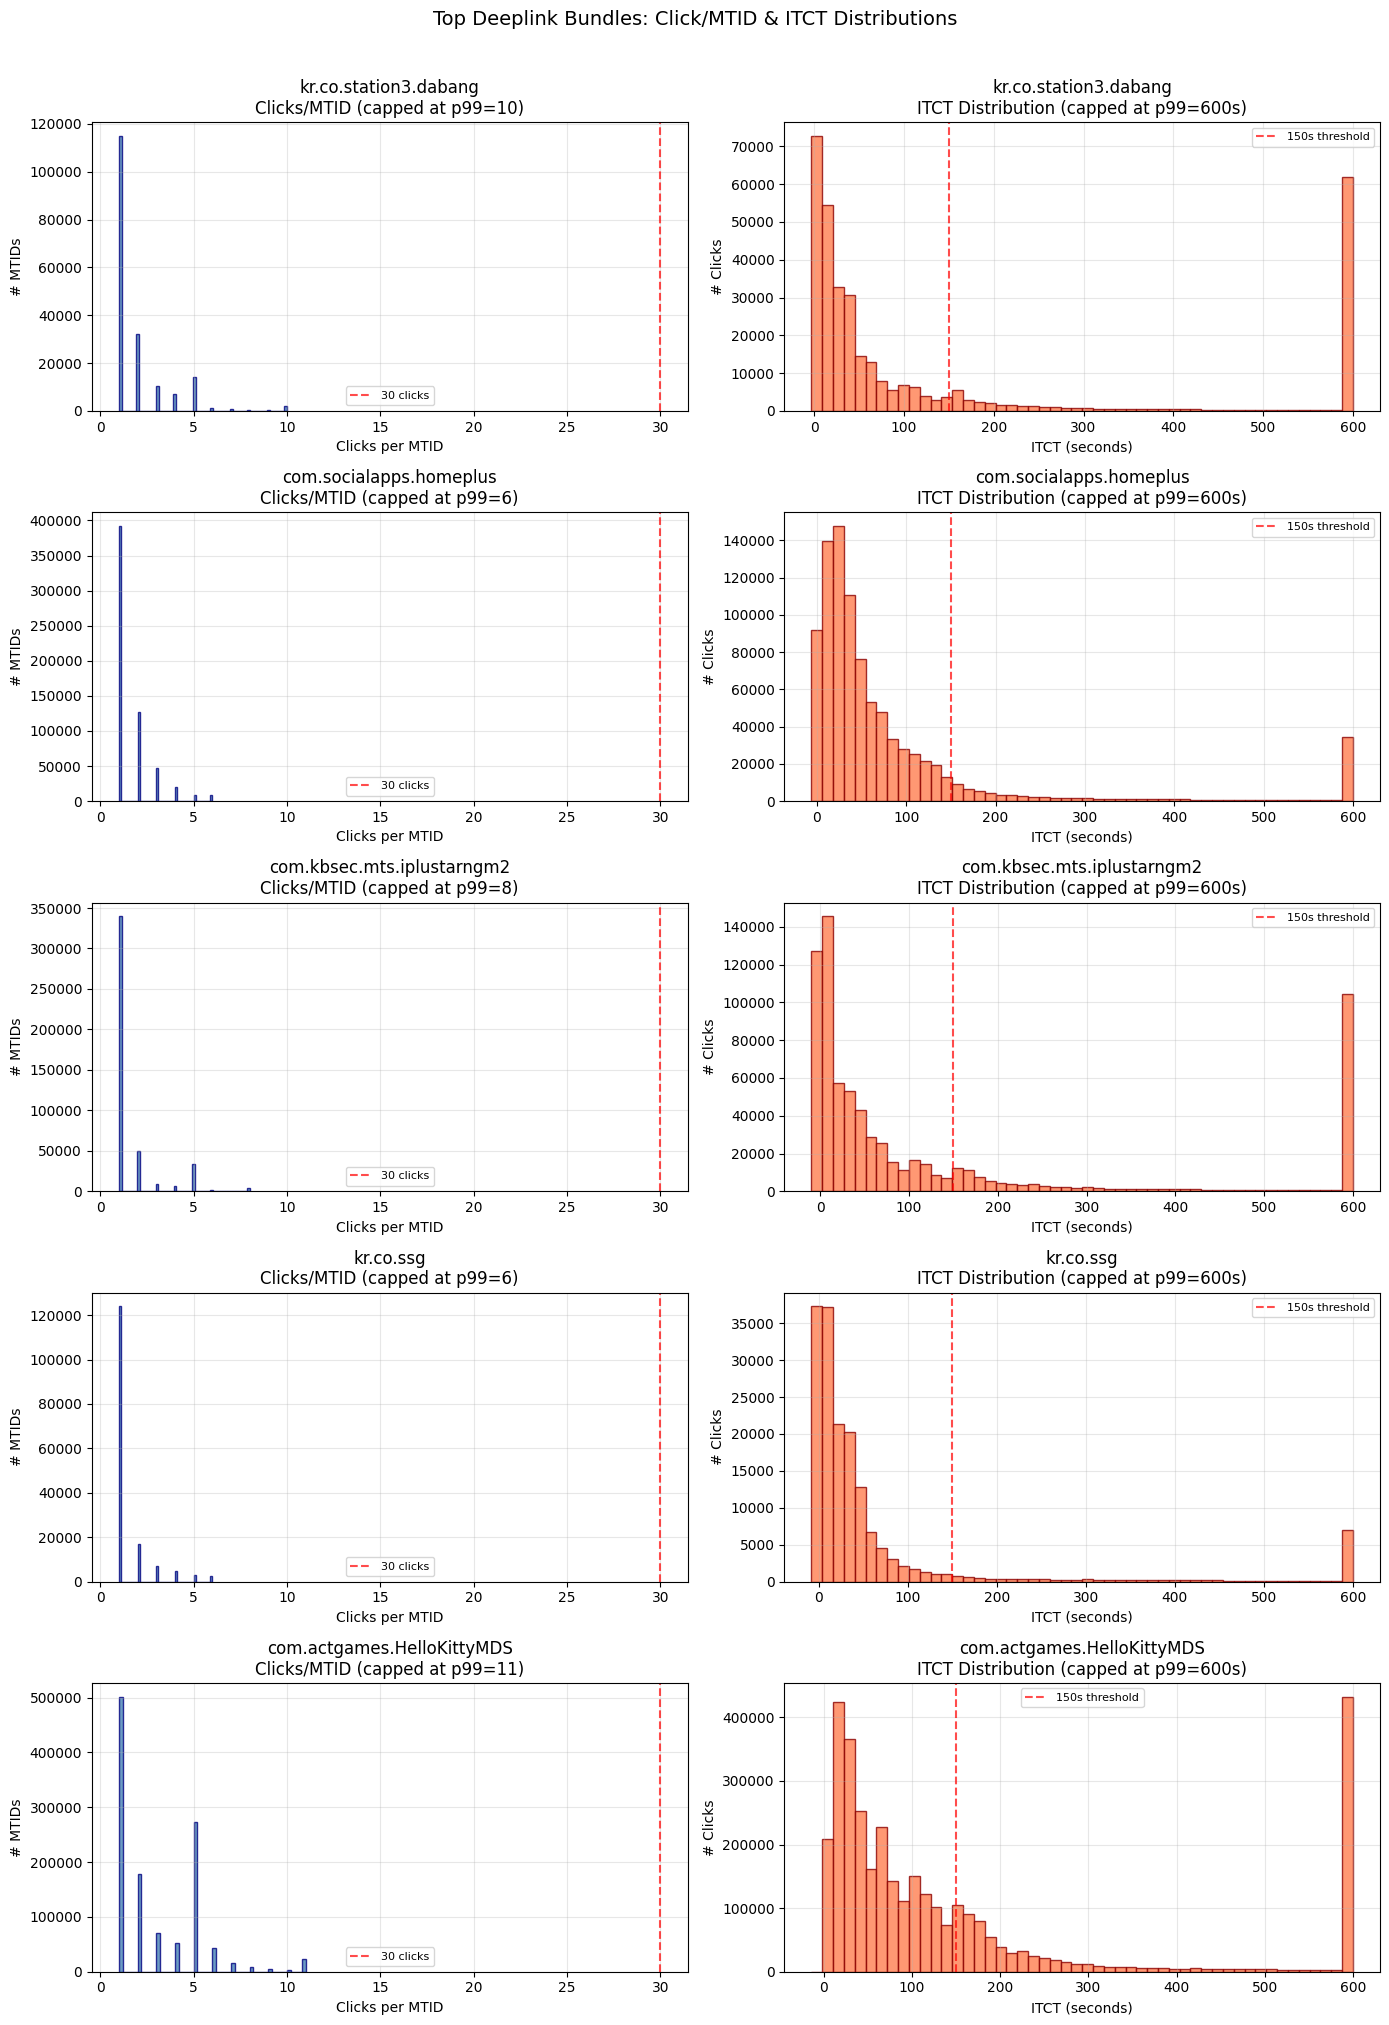

In [152]:
import matplotlib.pyplot as plt

n_bundles = len(ALL_BUNDLES)
fig, axes = plt.subplots(n_bundles, 2, figsize=(14, 4 * n_bundles))
if n_bundles == 1:
    axes = axes.reshape(1, -1)

for idx, bundle in enumerate(ALL_BUNDLES):
    bdf = df_bundle_clicks[df_bundle_clicks['app_bundle'] == bundle]
    if bdf.empty:
        axes[idx, 0].set_visible(False)
        axes[idx, 1].set_visible(False)
        continue

    clicks_per_mtid = bdf.groupby('mtid').size()
    itct = bdf['itct_sec'].dropna().astype(float)

    # Left: clicks per MTID histogram
    ax1 = axes[idx, 0]
    cap = int(clicks_per_mtid.quantile(0.99))
    ax1.hist(clicks_per_mtid.clip(upper=cap), bins=50, color='steelblue', edgecolor='navy', alpha=0.8)
    ax1.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='30 clicks')
    ax1.set_xlabel('Clicks per MTID')
    ax1.set_ylabel('# MTIDs')
    ax1.set_title(f'{bundle}\nClicks/MTID (capped at p99={cap})')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Right: ITCT histogram
    ax2 = axes[idx, 1]
    itct_cap = min(itct.quantile(0.99), 600)
    ax2.hist(itct.clip(upper=itct_cap), bins=50, color='coral', edgecolor='darkred', alpha=0.8)
    ax2.axvline(x=150, color='red', linestyle='--', alpha=0.7, label='150s threshold')
    ax2.set_xlabel('ITCT (seconds)')
    ax2.set_ylabel('# Clicks')
    ax2.set_title(f'{bundle}\nITCT Distribution (capped at p99={itct_cap:.0f}s)')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

plt.suptitle('Top Deeplink Bundles: Click/MTID & ITCT Distributions', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()